In [8]:
# -*- coding: utf-8 -*-
"""
Um ÚNICO gráfico 3D com z = tempo em janelas de 30 min.

x = LONGITUDE
y = LATITUDE
z = tempo discretizado (a cada 30 min), podendo ser:
    - "minutes": minutos desde o início (0, 30, 60, …)
    - "bin_index": índice do slot (0, 1, 2, …)

Requer: pandas, numpy, matplotlib
"""


'\nUm ÚNICO gráfico 3D com z = tempo em janelas de 30 min.\n\nx = LONGITUDE\ny = LATITUDE\nz = tempo discretizado (a cada 30 min), podendo ser:\n    - "minutes": minutos desde o início (0, 30, 60, …)\n    - "bin_index": índice do slot (0, 1, 2, …)\n\nRequer: pandas, numpy, matplotlib\n'

In [9]:
import os
from typing import Optional, Literal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import glob

In [10]:

# ======== CONFIG PADRÃO (ajuste se rodar direto) ========
DIRETORIO = "data/bus_csv/sul"
ROUND_COORD = 3           # casas para arredondar LAT/LON
JANELA_MIN = 30           # tamanho do “slot” temporal (min)
Z_MODE: Literal["minutes","bin_index"] = "minutes"  # ou "bin_index"
FILTRAR_PARKING_NULO = True
# =========================================================

In [11]:
def _inferir_coluna_datetime(df: pd.DataFrame) -> str:
    cand_lower = [c.lower() for c in df.columns]
    candidatos = [
        "timestamp","datahora","datetime","gps_datetime",
        "hora","time","date_time","created_at"
    ]
    for cand in candidatos:
        if cand in cand_lower:
            return df.columns[cand_lower.index(cand)]
    # Heurística
    for c in df.columns:
        try:
            s = pd.to_datetime(df[c].head(20), errors="coerce", dayfirst=True, infer_datetime_format=True)
            if s.notna().mean() > 0.8:
                return c
        except Exception:
            pass
    raise ValueError(
        f"Não encontrei automaticamente a coluna de data/hora. Colunas: {list(df.columns)}.\n"
        "→ Passe dt_col explicitamente se souber."
    )


In [12]:
def _garantir_lat_lon(df: pd.DataFrame, round_val: int) -> pd.DataFrame:
    if "LATITUDE" in df.columns and "LONGITUDE" in df.columns:
        out = df.copy()
        out["LATITUDE"] = out["LATITUDE"].round(round_val)
        out["LONGITUDE"] = out["LONGITUDE"].round(round_val)
        return out
    lat_col = lon_col = None
    for c in df.columns:
        lc = c.lower()
        if lat_col is None and lc in {"lat","latitude","y","latitud"}:
            lat_col = c
        if lon_col is None and lc in {"lon","lng","long","longitude","x","longitud"}:
            lon_col = c
    if lat_col is None or lon_col is None:
        raise ValueError("Não encontrei colunas de latitude/longitude (ex.: LATITUDE/LONGITUDE, lat/lon).")
    out = df.rename(columns={lat_col:"LATITUDE", lon_col:"LONGITUDE"}).copy()
    out["LATITUDE"] = out["LATITUDE"].round(round_val)
    out["LONGITUDE"] = out["LONGITUDE"].round(round_val)
    return out


In [13]:
def unico_3d_com_tempo(
    csv_path: str,
    round_coord: int = 3,
    janela_min: int = 30,
    z_mode: Literal["minutes","bin_index"] = "minutes",
    dt_col: Optional[str] = None,
    filtrar_parking_nulo: bool = True,
    figsize=(11, 8),
    dpi=150,
    out_png: Optional[str] = None,
):
    df = pd.read_csv(csv_path)

    # 1) data/hora
    if dt_col is None:
        dt_col = _inferir_coluna_datetime(df)
    df["__dt"] = pd.to_datetime(df[dt_col], errors="coerce", dayfirst=True, infer_datetime_format=True)
    df = df.dropna(subset=["__dt"]).copy()

    # 2) filtro PARKING
    if filtrar_parking_nulo and "PARKING" in df.columns:
        df = df[df["PARKING"].isna()].copy()

    # 3) lat/lon arredondado
    df = _garantir_lat_lon(df, round_coord)

    # 4) construir slots de 30 min
    freq_str = f"{int(janela_min)}T"
    df["__slot_start"] = df["__dt"].dt.floor(freq_str)

    # 5) eixo Z
    start0 = df["__slot_start"].min()
    if z_mode == "minutes":
        # z = minutos desde o início (múltiplos de 30)
        z = (df["__slot_start"] - start0).dt.total_seconds() / 60.0
    elif z_mode == "bin_index":
        # z = índice do slot (0, 1, 2, …)
        slots_ordenados = np.sort(df["__slot_start"].unique())
        mapa = {t: i for i, t in enumerate(slots_ordenados)}
        z = df["__slot_start"].map(mapa).astype(float)
    else:
        raise ValueError("z_mode deve ser 'minutes' ou 'bin_index'.")

    # 6) título/linha
    linha = None
    if "LINE" in df.columns and not df["LINE"].dropna().empty:
        linha = str(df["LINE"].dropna().iloc[0])

    # 7) plot 3D único
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection="3d")

    # Dispersão
    ax.scatter(
        df["LONGITUDE"].values,
        df["LATITUDE"].values,
        z.values,
        s=6  # pontos pequenos para reduzir poluição visual
    )

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_zlabel("Tempo (30 em 30 min)")

    # Limites de Z e ticks amigáveis
    zmin, zmax = float(np.nanmin(z)), float(np.nanmax(z))
    ax.set_zlim(zmin - 0.5, zmax + 0.5)

    if z_mode == "minutes":
        # ticks a cada 60 min (ajuste se quiser)
        step = 60
        ticks = np.arange(0, (zmax // step + 2) * step, step)
        ax.set_zticks(ticks)
        # rótulos com horário real (usar o início como referência)
        labels = [(start0 + pd.Timedelta(minutes=float(t))).strftime("%d/%m %H:%M") for t in ticks]
        ax.set_zticklabels(labels, rotation=0, ha="right")
        titulo_z = "Minutos desde o início"
    else:
        # bin_index: ticks inteiros
        ax.zaxis.set_major_locator(MaxNLocator(integer=True))
        # rótulos com horário do slot correspondente (mostra no máximo ~10)
        slots = np.sort(df["__slot_start"].unique())
        max_labels = 10
        if len(slots) > max_labels:
            idx = np.linspace(0, len(slots) - 1, max_labels).round().astype(int)
            show_idx = set(idx.tolist())
        else:
            show_idx = set(range(len(slots)))
        tick_positions = []
        tick_labels = []
        for i, ts in enumerate(slots):
            if i in show_idx:
                tick_positions.append(i)
                tick_labels.append(pd.to_datetime(ts).strftime("%d/%m %H:%M"))
        ax.set_zticks(tick_positions)
        ax.set_zticklabels(tick_labels, rotation=0, ha="right")
        titulo_z = "Índice do slot (30 min)"

    titulo_linha = f"Linha {linha} — " if linha else ""
    ax.set_title(f"{titulo_linha}Dispersão 3D com tempo em slots de {janela_min} min\nZ = {titulo_z}")

    plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=dpi)
        print(f"Figura salva em: {out_png}")
    else:
        plt.show()

C:\Users\bruno\AppData\Local\Temp\ipykernel_8348\934705036.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[c].head(20), errors="coerce", dayfirst=True, infer_datetime_format=True)
C:\Users\bruno\AppData\Local\Temp\ipykernel_8348\934705036.py:13: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  s = pd.to_datetime(df[c].head(20), errors="coerce", dayfirst=True, infer_datetime_format=True)
C:\Users\bruno\AppData\Local\Temp\ipykernel_8348\259036577.py:17: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-

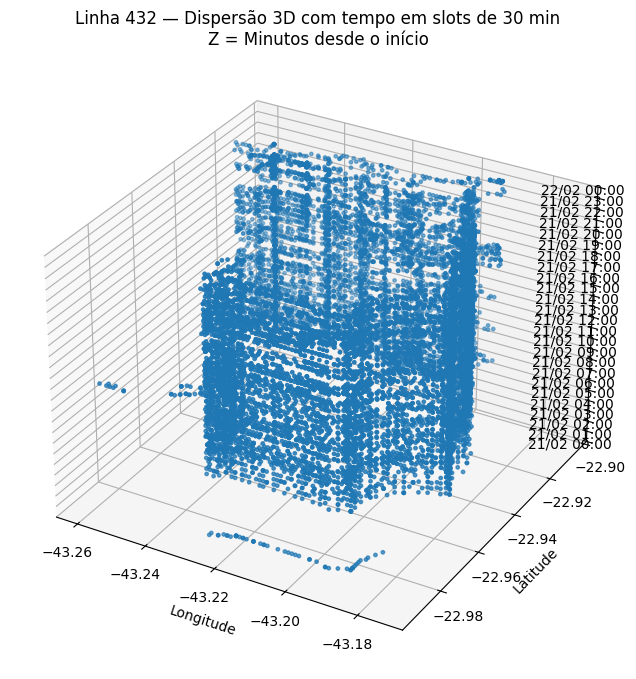

C:\Users\bruno\AppData\Local\Temp\ipykernel_8348\934705036.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[c].head(20), errors="coerce", dayfirst=True, infer_datetime_format=True)
C:\Users\bruno\AppData\Local\Temp\ipykernel_8348\934705036.py:13: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  s = pd.to_datetime(df[c].head(20), errors="coerce", dayfirst=True, infer_datetime_format=True)
C:\Users\bruno\AppData\Local\Temp\ipykernel_8348\259036577.py:17: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-

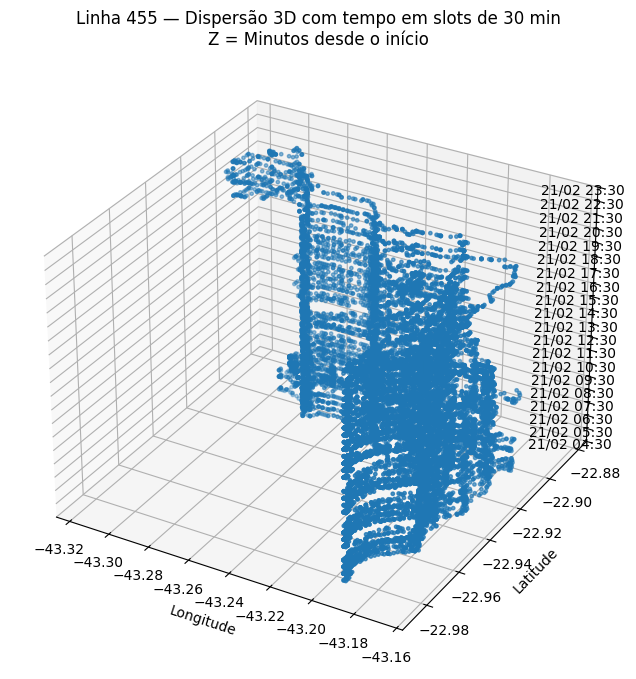

C:\Users\bruno\AppData\Local\Temp\ipykernel_8348\934705036.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[c].head(20), errors="coerce", dayfirst=True, infer_datetime_format=True)
C:\Users\bruno\AppData\Local\Temp\ipykernel_8348\934705036.py:13: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  s = pd.to_datetime(df[c].head(20), errors="coerce", dayfirst=True, infer_datetime_format=True)
C:\Users\bruno\AppData\Local\Temp\ipykernel_8348\259036577.py:17: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-

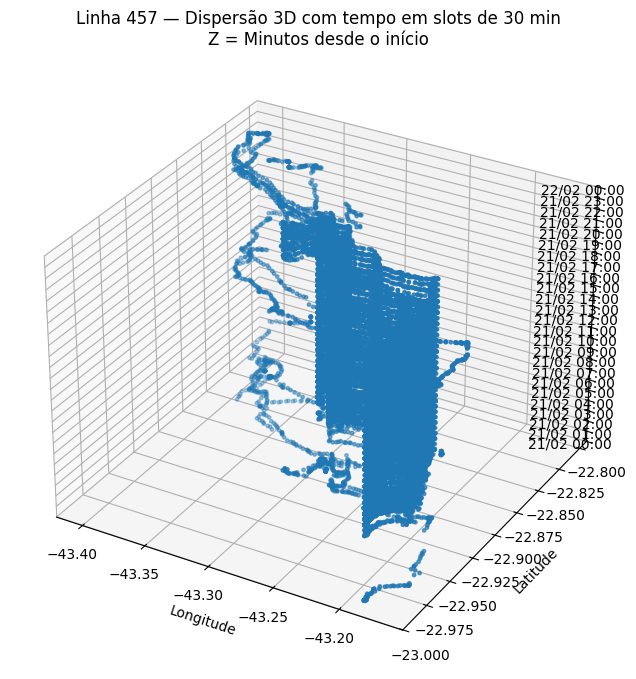

C:\Users\bruno\AppData\Local\Temp\ipykernel_8348\934705036.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[c].head(20), errors="coerce", dayfirst=True, infer_datetime_format=True)
C:\Users\bruno\AppData\Local\Temp\ipykernel_8348\934705036.py:13: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  s = pd.to_datetime(df[c].head(20), errors="coerce", dayfirst=True, infer_datetime_format=True)
C:\Users\bruno\AppData\Local\Temp\ipykernel_8348\259036577.py:17: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-

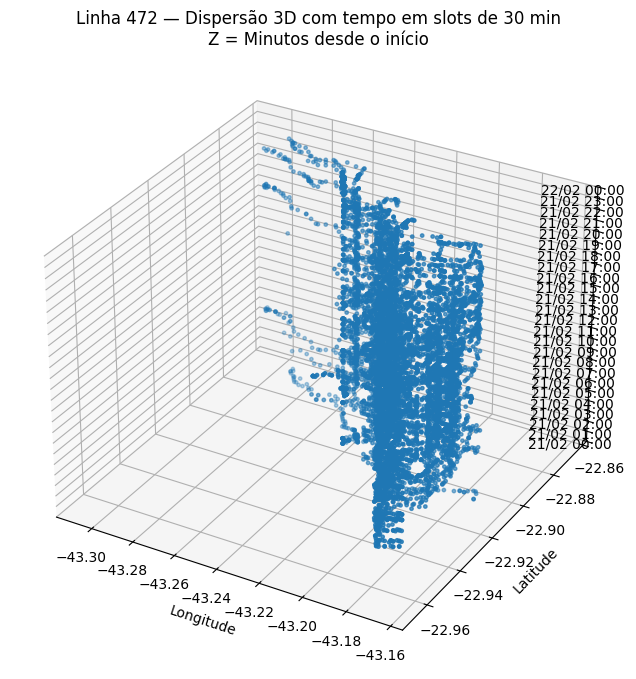

C:\Users\bruno\AppData\Local\Temp\ipykernel_8348\934705036.py:13: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(df[c].head(20), errors="coerce", dayfirst=True, infer_datetime_format=True)
C:\Users\bruno\AppData\Local\Temp\ipykernel_8348\934705036.py:13: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  s = pd.to_datetime(df[c].head(20), errors="coerce", dayfirst=True, infer_datetime_format=True)
C:\Users\bruno\AppData\Local\Temp\ipykernel_8348\259036577.py:17: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-

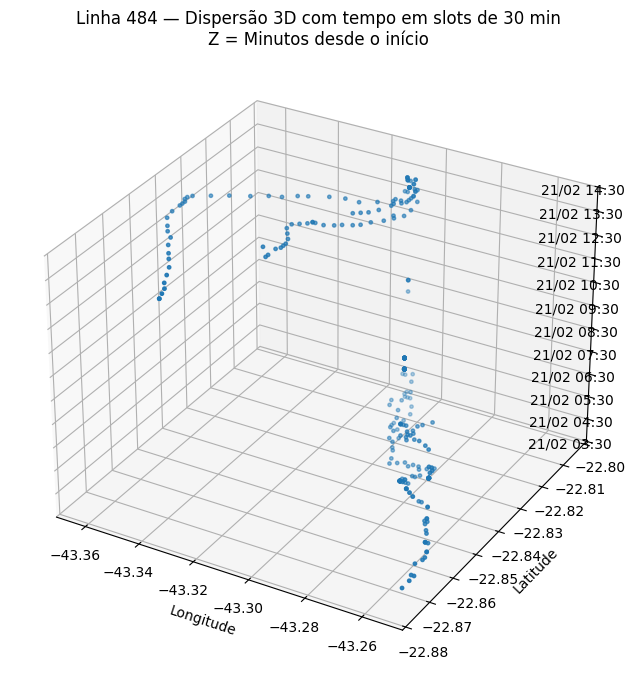

In [14]:


if __name__ == "__main__":
    arquivos_csv = glob.glob(os.path.join(DIRETORIO, "*.csv"))
    for arquivo in arquivos_csv:
        # Exemplo de uso:
        unico_3d_com_tempo(
            csv_path=arquivo,
            round_coord=ROUND_COORD,
            janela_min=JANELA_MIN,
            z_mode=Z_MODE,                 # "minutes" ou "bin_index"
            dt_col=None,                   # preencha se souber o nome exato (ex.: "DATAHORA")
            filtrar_parking_nulo=FILTRAR_PARKING_NULO,
            out_png=None,                  # ou algo como "./unico_3d_slots30.png"
        )
